In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import torch

sys.path.append('./src')
from msg.msg import MSGNet
from msg.visualization import render_disparity
from losses.msev import MSEv

%matplotlib inline

#### Load data

In [2]:
data = {}
samples = 'lucy', 'plant', 'vintage'

for sample in samples:
    data[sample] = {}
    for modality in 'disparity', 'rgb':
        with open(f'data/{sample}_{modality}.npy', 'rb') as file:
            data[sample][modality] = torch.from_numpy(np.load(file))
    with open(f'data/{sample}_calibration.npy', 'rb') as file:
        data[sample]['calibration'] = np.load(file, allow_pickle=True).item()

#### Calculate low resolution images

In [3]:
def box_downsample(ar, factor):
    return torch.nn.functional.interpolate(ar, scale_factor=1/factor, mode='area')


def upsample(ar, factor):
    # try changing 'bilinear' to 'area'
    return torch.nn.functional.interpolate(ar, scale_factor=factor, mode='bilinear')

In [4]:
for sample in samples:
    _ = box_downsample(data[sample]['disparity'][None, None], 4)
    _ = upsample(_, 4)
    data[sample]['lr4_disparity'] = _[0, 0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


#### Compare MSEv and regular MSE

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


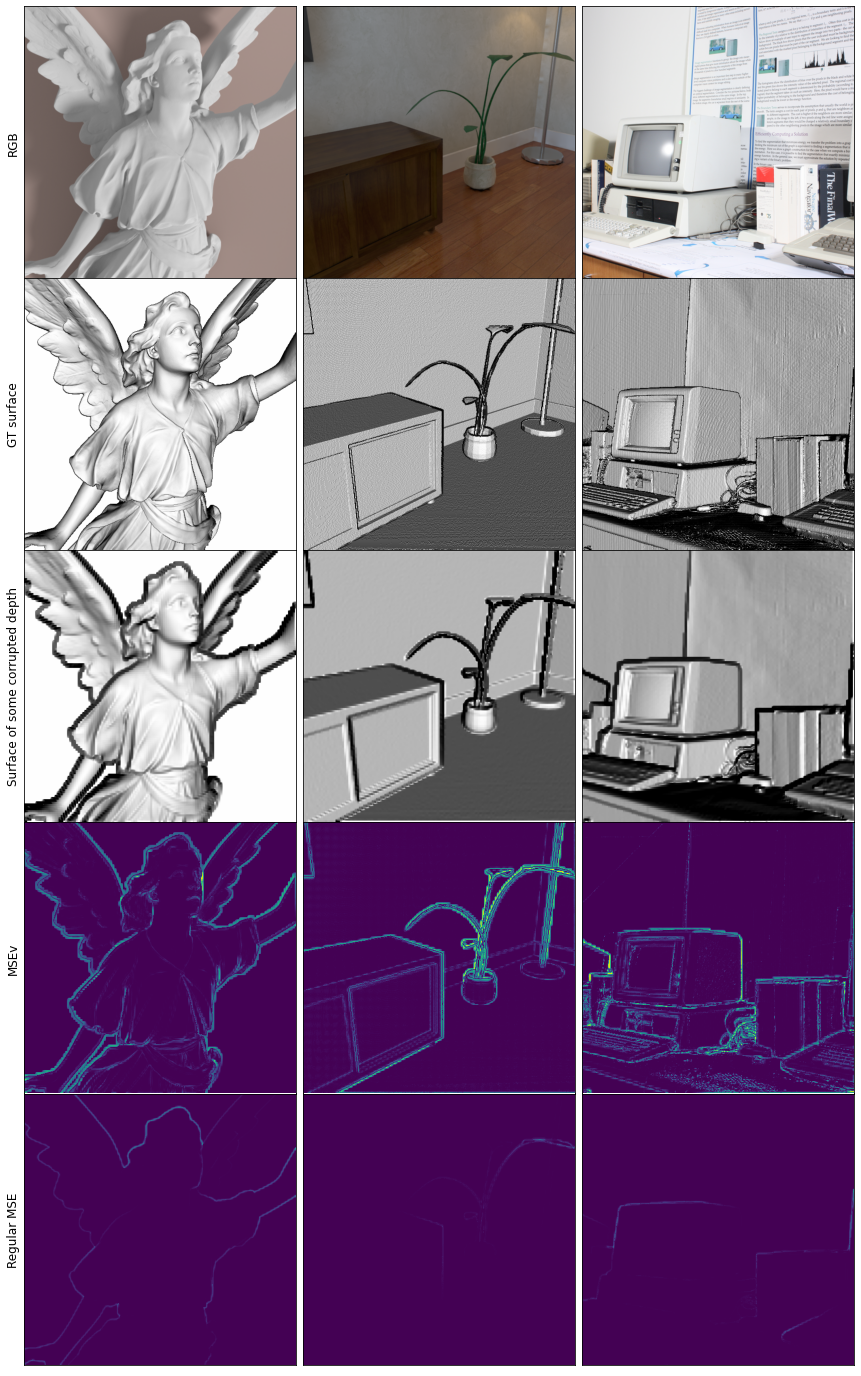

In [5]:
msev = MSEv('disparity', reduction='none')
mse = torch.nn.MSELoss(reduction='none')


fig, axes = plt.subplots(5, len(samples), figsize=[5 * len(samples), 5 * 5])
for axes_ in axes:
    for ax in axes_:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
labels = ['RGB', 'GT surface', 'Surface of some corrupted depth', 'MSEv', 'Regular MSE']
for i, ax in enumerate(axes):
    ax = ax[0]
    ax.yaxis.set_label_position('left')
    ax.set_ylabel(labels[i], fontsize=12)

for sample_i, sample in enumerate(samples):
    axes[0][sample_i].imshow(data[sample]['rgb'])
    d = data[sample]['disparity']
    d_low = data[sample]['lr4_disparity']
    calib = data[sample]['calibration']
    light = [0, 0, 1]
    axes[1][sample_i].imshow(render_disparity(d, calibration=calib, light_dir=light))
    axes[2][sample_i].imshow(render_disparity(d_low, calibration=calib, light_dir=light))
    axes[3][sample_i].imshow(msev(d_low, d, calibration=calib)[0, 0])
    axes[4][sample_i].imshow(mse(d_low[None, None], d[None, None])[0, 0])
    
fig.subplots_adjust(wspace=0, hspace=0)